In [1]:
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
import math
from scipy import stats
plt.rc("figure", figsize=(20,20))
plt.rc("font", size=14)

In [2]:
holdout=pd.read_csv('/Users/Ben/Desktop/optimal_decision_trees/data/holdout.csv')
print(holdout.shape[0])

28317


In [3]:
holdout_glm=pd.read_csv('/Users/Ben/Desktop/optimal_decision_trees/outputs/holdout_glm_predictions.csv')
print(holdout_glm.shape[0])

holdout_odt=pd.read_csv('/Users/Ben/Desktop/optimal_decision_trees/outputs/holdout_odt_predictions.csv')
print(holdout_odt.shape[0])

holdout_xgb=pd.read_csv('/Users/Ben/Desktop/optimal_decision_trees/outputs/holdout_xgb_predictions.csv')
print(holdout_xgb.shape[0])

28317
28317
28317


# MAE

In [4]:
model_name=['glm', 'odt', 'xgb']
y_pred=[holdout_glm.glm_pred, holdout_odt.loss, holdout_xgb.loss]
y_valid=holdout['loss']

for i,v in zip(model_name,y_pred):

    result=mean_absolute_error(v, y_valid)
    print(i, 'mae result: ', result)

glm mae result:  1630.3534628224277
odt mae result:  1563.9962800484848
xgb mae result:  1191.179014525903


# GINI

In [5]:
def G(v):
    bins = np.linspace(0., 100., 11)
    total = float(np.sum(v))
    yvals = []
    for b in bins:
        bin_vals = v[v <= np.percentile(v, b)]
        bin_fraction = (np.sum(bin_vals) / total) * 100.0
        yvals.append(bin_fraction)
    # perfect equality area
    pe_area = np.trapz(bins, x=bins)
    # lorenz area
    lorenz_area = np.trapz(yvals, x=bins)
    gini_val = (pe_area - lorenz_area) / float(pe_area)
    return bins, yvals, gini_val

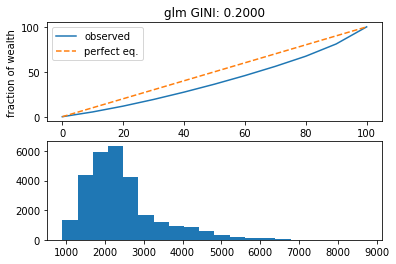

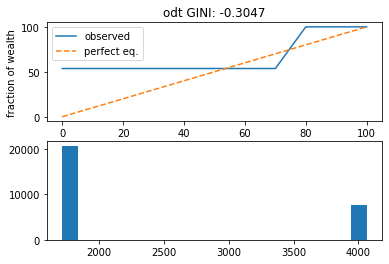

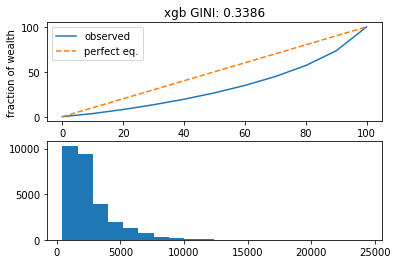

In [6]:
for i,u in zip(model_name,y_pred):
    
    v=u
    bins, result, gini_val = G(v)
    plt.figure()
    plt.subplot(2, 1, 1)
    plt.plot(bins, result, label="observed")
    plt.plot(bins, bins, '--', label="perfect eq.")
    plt.xlabel("fraction of population")
    plt.ylabel("fraction of wealth")
    plt.title(f"{i} GINI: %.4f" %(gini_val))
    plt.legend()
    plt.subplot(2, 1, 2)
    plt.hist(v, bins=20)

# X-GRAPH

In [11]:
#holdout_odt.glm_pred 
import numpy as np

def create_xgraph(holdout, holdout_xgb, holdout_odt, holdout_glm):

    # dataframe joins
    xgraph=holdout[['id', 'loss']].merge(holdout_xgb, on=['id'])\
    .merge(holdout_glm, on=['id']).merge(holdout_odt, on=['id'])
    xgraph.columns=['id', 'loss_actual', 'loss_xgb', 'loss_glm', 'loss_odt']
    
    # calculations
    xgraph['model_actual_glm']=(xgraph['loss_actual']/xgraph['loss_glm'])*100
    xgraph['model_xgb_glm']=(xgraph['loss_xgb']/xgraph['loss_glm'])*100 # scaled to actuals
    xgraph['model_odt_glm']=(xgraph['loss_odt']/xgraph['loss_glm'])*100
    xgraph['model_glm_glm']=(xgraph['loss_glm']/xgraph['loss_glm'])*100
    
    # levels
    labels=list(np.arange(0, 401, 10))
    bins=list(np.arange(0, 401, 10))
    bins.append(np.inf)

    # calculations
    xgraph['model_actual_glm_banded'] = pd.cut(xgraph['model_actual_glm'], bins=bins, labels=labels)    
    exposure=xgraph.groupby('model_actual_glm_banded')['loss_actual'].count().to_list()
    actuals=xgraph.groupby('model_actual_glm_banded')['model_actual_glm'].mean().to_list()
    xgb=xgraph.groupby('model_actual_glm_banded')['model_xgb_glm'].mean().to_list()
    odt=xgraph.groupby('model_actual_glm_banded')['model_odt_glm'].mean().to_list()
    glm=xgraph.groupby('model_actual_glm_banded')['model_glm_glm'].mean().to_list()
    
    # Bar plot
    plt.rcParams["figure.figsize"] = (20,20)
    N=len(exposure)
    width = 5
    plt.bar(labels, exposure, width, color='gold', label='Diff')

    # Line plot
    axes2 = plt.twinx()
    axes2.plot(labels, actuals, color='k', label='Actual')
    axes2.plot(labels, xgb, color='r', label='XGB')
    axes2.plot(labels, odt, color='g', label='ODT')
    axes2.plot(labels, glm, color='b', label='GLM')
    axes2.set_ylim(min(actuals), max(actuals))
    axes2.set_ylabel('Exposure')
    
    # legend and settings
    plt.legend(loc="upper left")

    plt.show()

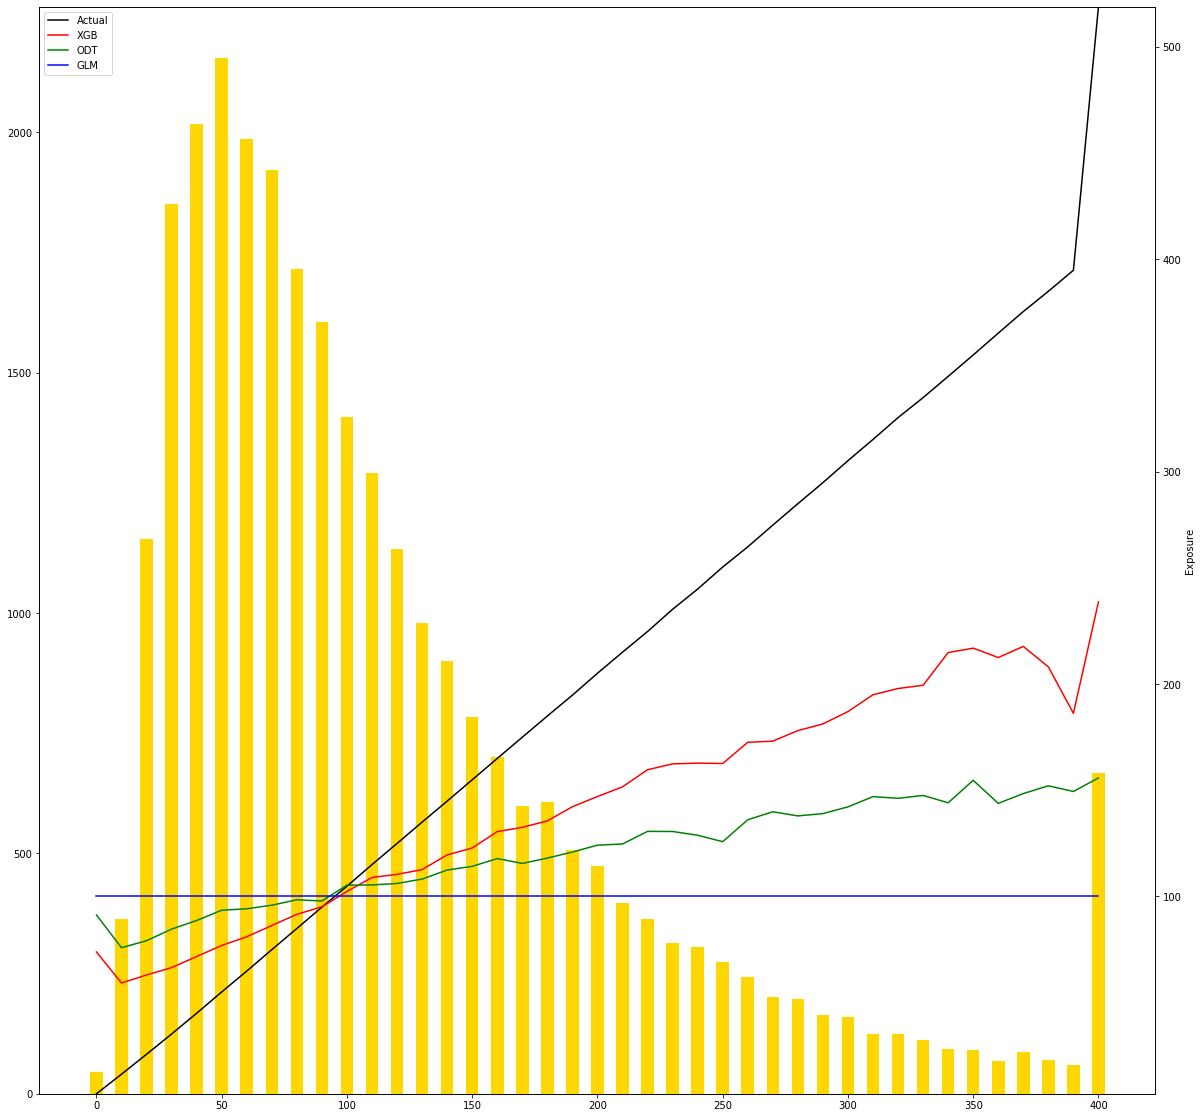

In [12]:
create_xgraph(holdout, holdout_xgb, holdout_odt, holdout_glm)